# Analysis of Scaling for Molecular ISDF

#### Repeated Reference Data

Reference ACE, with consistent spacing (same spacing for all calcs). Root directory:

```shell
/home/bucchera/exchange_calcs/ace_references
```

#### Repeated ISDF Calculations

ISDF, with varying numbers of ISDF vectors, according to $c N_{occ}$, rather than using the recommendation from the 
rank of the Gram matrix. Should give a fairer comparison of the scaling/speed-up, as:

a) I'm not convinced that the rank of the Gram matrix is necessarily a useful metric if the points are seeded badly
b) The prior data set doesn't give a systematic timing/scaling analysis, as it was based on the premise that I had chosen
the optimal number of points for accuracy. As I showed, the accuracy varied from 1.e-8 to 1.e-6.

Root directory:

```shell
~/exchange_calcs/nisdf_vector_scaling
```

### Running on the Remote

On MPSD:
```
tmux new -s jlab
source programs/isdfBenchmarks/.venv/bin/activate
jupyter lab --no-browser --ip=0.0.0.0 --port 8888
```

Detach with `Ctrl-b d`
Reattach with: `tmux attach -t jlab`
Paste the Jupyter URL into `Settings > Jupyter > Jupyter Servers > Configured servers`


In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
from typing import List
from pathlib import Path

from isdfbenchmarks.parser.profiling import parse_time
from isdfbenchmarks.parser import stdout


# Functions
def parse_scf_times(root: Path, molecules: List[str]) -> dict:
    scf = {}
    for molecule in molecules:
        file = root / molecule / 'terminal.out'
        with open(file, mode='r') as fid:
            lines = fid.read()
        scf[molecule] = stdout.parse_scf_time(lines)
    return scf


def average_scf_times(scf: dict) -> np.ndarray:
    """Given a set of SCF times, average them out
    
    :param scf: Dict of SCF results for Nmolecules
    :return: 
    """
    n_molecules = len(list(scf))
    avg_scf = np.empty(shape=(n_molecules))
    for i, times in enumerate(scf.values()):
        avg_scf[i] = np.mean([time for time in times.values()])
    return avg_scf
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
""" Avg SCF time vs N_isdf vectors

KMeans run ONLY for the first SCF step, consistent with what Head-Gordon does
"""

# All single node jobs. 4 MPI, 8 OMP per process
molecules = ['anthracene', 'tetracene', 'pentacene', 'ether_crown']

# Occupations
nocc = {'anthracene': 33, 'tetracene': 42, 'pentacene': 51, 'ether_crown': 54}

# Directories
ref_root = Path("/home/bucchera/exchange_calcs/ace_references")
isdf_root = Path("/home/bucchera/exchange_calcs/nisdf_vector_scaling")
isdf_subdirs = ['5_nocc', '7.5_nocc', '10_nocc', '15_nocc']

ref_scf = parse_scf_times(ref_root, molecules)
isdf_scf_5nocc = parse_scf_times(isdf_root / '5_nocc', molecules)
isdf_scf_7_5nocc = parse_scf_times(isdf_root / '7.5_nocc', molecules)
isdf_scf_10nocc = parse_scf_times(isdf_root / '10_nocc', molecules)
isdf_scf_15nocc = parse_scf_times(isdf_root / '15_nocc', molecules)


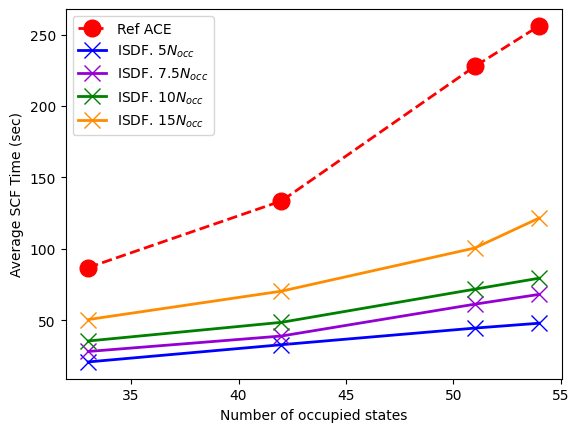

In [83]:
""" Plot Avg SCF time vs N_isdf vectors
"""
import matplotlib.pyplot as plt

avg_scf_ref = average_scf_times(ref_scf)
avg_scf_5nocc = average_scf_times(isdf_scf_5nocc)
avg_scf_7_5nocc = average_scf_times(isdf_scf_7_5nocc)
avg_scf_10nocc = average_scf_times(isdf_scf_10nocc)
avg_scf_15nocc = average_scf_times(isdf_scf_15nocc)

occupied = [occ for occ in nocc.values()] 
plt.plot(occupied, avg_scf_ref, 'ro--', linewidth=2, markersize=12, label="Ref ACE")
plt.plot(occupied, avg_scf_5nocc, 'bx-', linewidth=2, markersize=12, label=r"ISDF. $5N_{occ}$")
plt.plot(occupied, avg_scf_7_5nocc, 'x-', color="darkviolet", linewidth=2, markersize=12, label=r"ISDF. $7.5 N_{occ}$")
plt.plot(occupied, avg_scf_10nocc, 'x-', color="green", linewidth=2, markersize=12, label=r"ISDF. $10 N_{occ}$")
plt.plot(occupied, avg_scf_15nocc, 'x-', color="darkorange", linewidth=2, markersize=12, label=r"ISDF. $15 N_{occ}$")

plt.xlabel("Number of occupied states")
plt.ylabel("Average SCF Time (sec)")
plt.legend()

save_image = True
if save_image:
    # Remote path
    file = Path.cwd() / "programs/isdfBenchmarks/jupyter/images"
    plt.savefig(file / "avg_scf_time.png", dpi=300, bbox_inches="tight")

plt.show()


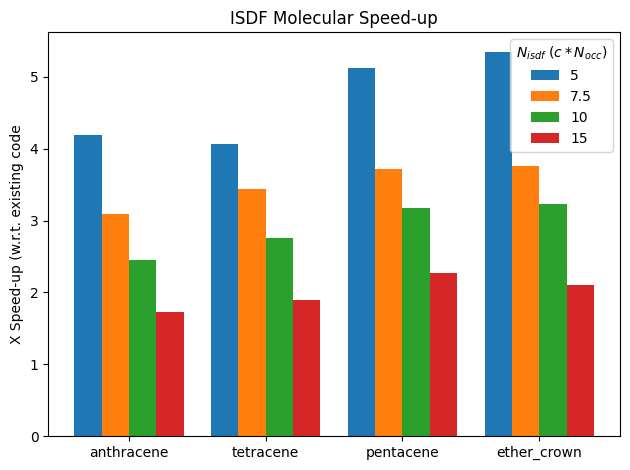

In [84]:
"""
Plot speed-up w.r.t reference for each set of interpolation vectors - bar plot
"""
import numpy as np
import matplotlib.pyplot as plt

# Repackage data
speedup = {}
for i, molecule in enumerate(molecules):
    speedup[molecule] =  np.array([avg_scf_5nocc[i], avg_scf_7_5nocc[i], avg_scf_10nocc[i], avg_scf_15nocc[i]])
    speedup[molecule] =  avg_scf_ref[i] / speedup[molecule]
    

labels = list(speedup.keys()) 
vals = np.vstack([speedup[k] for k in labels])     # shape: (n_groups, 4)
n_groups, n_bars = vals.shape

x = np.arange(n_groups)                         # group positions
group_width = 0.8                               # total width occupied by each group
bar_width = group_width / n_bars

# center the block of bars on each group tick
offsets = (np.arange(n_bars) - (n_bars - 1) / 2) * bar_width

pre_factors = [5, 7.5, 10, 15]
for i in range(n_bars):
    plt.bar(x + offsets[i], vals[:, i], width=bar_width, label=f'{pre_factors[i]}')

plt.xticks(x, labels, rotation=0)
plt.ylabel('X Speed-up (w.r.t. existing code')
plt.title('ISDF Molecular Speed-up')
plt.legend(title=r'$N_{isdf}$ ($c * N_{occ}$)')
plt.tight_layout()

save_image = True
if save_image:
    # Remote path
    file = Path.cwd() / "programs/isdfBenchmarks/jupyter/images"
    plt.savefig(file / "speedup_barplot.png", dpi=300, bbox_inches="tight")

plt.show()



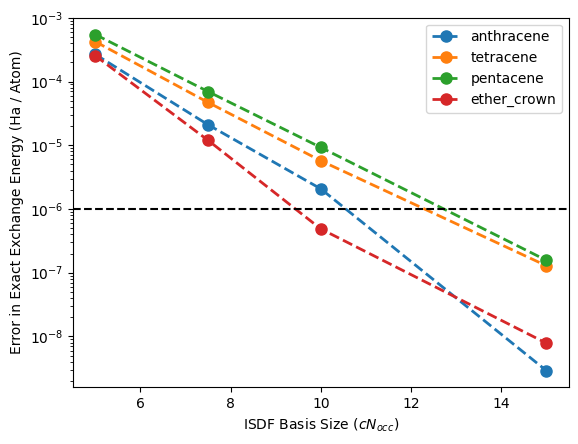

In [87]:
"""Error as a function of ISDF vector basis size
* Parse
* Plot
"""
import copy

from isdfbenchmarks.parser import static

# Converged exact exchange energies, per molecule
ref_exx = {}
for molecule in molecules:
    ref_exx[molecule] = static.info_file(ref_root / molecule)['Energy']['Exchange']
    
# ISDF exact exchange energies
isdf_exx = {}
for molecule in molecules:
    # Energies as a function of the number of ISDF vectors (== c * Nocc)
    energies = np.empty(shape=len(isdf_subdirs))
    for i, subdir in enumerate(isdf_subdirs):
        energies[i] = static.info_file(isdf_root / subdir / molecule)['Energy']['Exchange']
    isdf_exx[molecule] = copy.deepcopy(energies)

# Pre-factors to get total number of ISDF vectors
prefactors = [5.0, 7.5, 10.0, 15.0]
n_atoms = {"anthracene": 24.0, "tetracene": 30.0, "pentacene": 36.0, "ether_crown": 42.0}
# n_isdf_vectors = [c * nocc[molecule] for c in prefactors]

# Error plot
for molecule in molecules:
    exx_error = (isdf_exx[molecule] - ref_exx[molecule]) / n_atoms[molecule]
    plt.plot(prefactors, exx_error, 'o--', linewidth=2, markersize=8, label=molecule)

plt.xlabel(r"ISDF Basis Size ($c N_{occ}$)")
plt.ylabel("Error in Exact Exchange Energy (Ha / Atom)")
plt.yscale('log')
xmin, xmax = plt.xlim() 
plt.hlines(1.e-6, xmin, xmax, colors="black", linestyles='dashed')
plt.xlim(xmin, xmax)
plt.legend()

save_image = True
if save_image:
    # Remote path
    file = Path.cwd() / "programs/isdfBenchmarks/jupyter/images"
    plt.savefig(file / "exx_error.png", dpi=300, bbox_inches="tight")

plt.show()


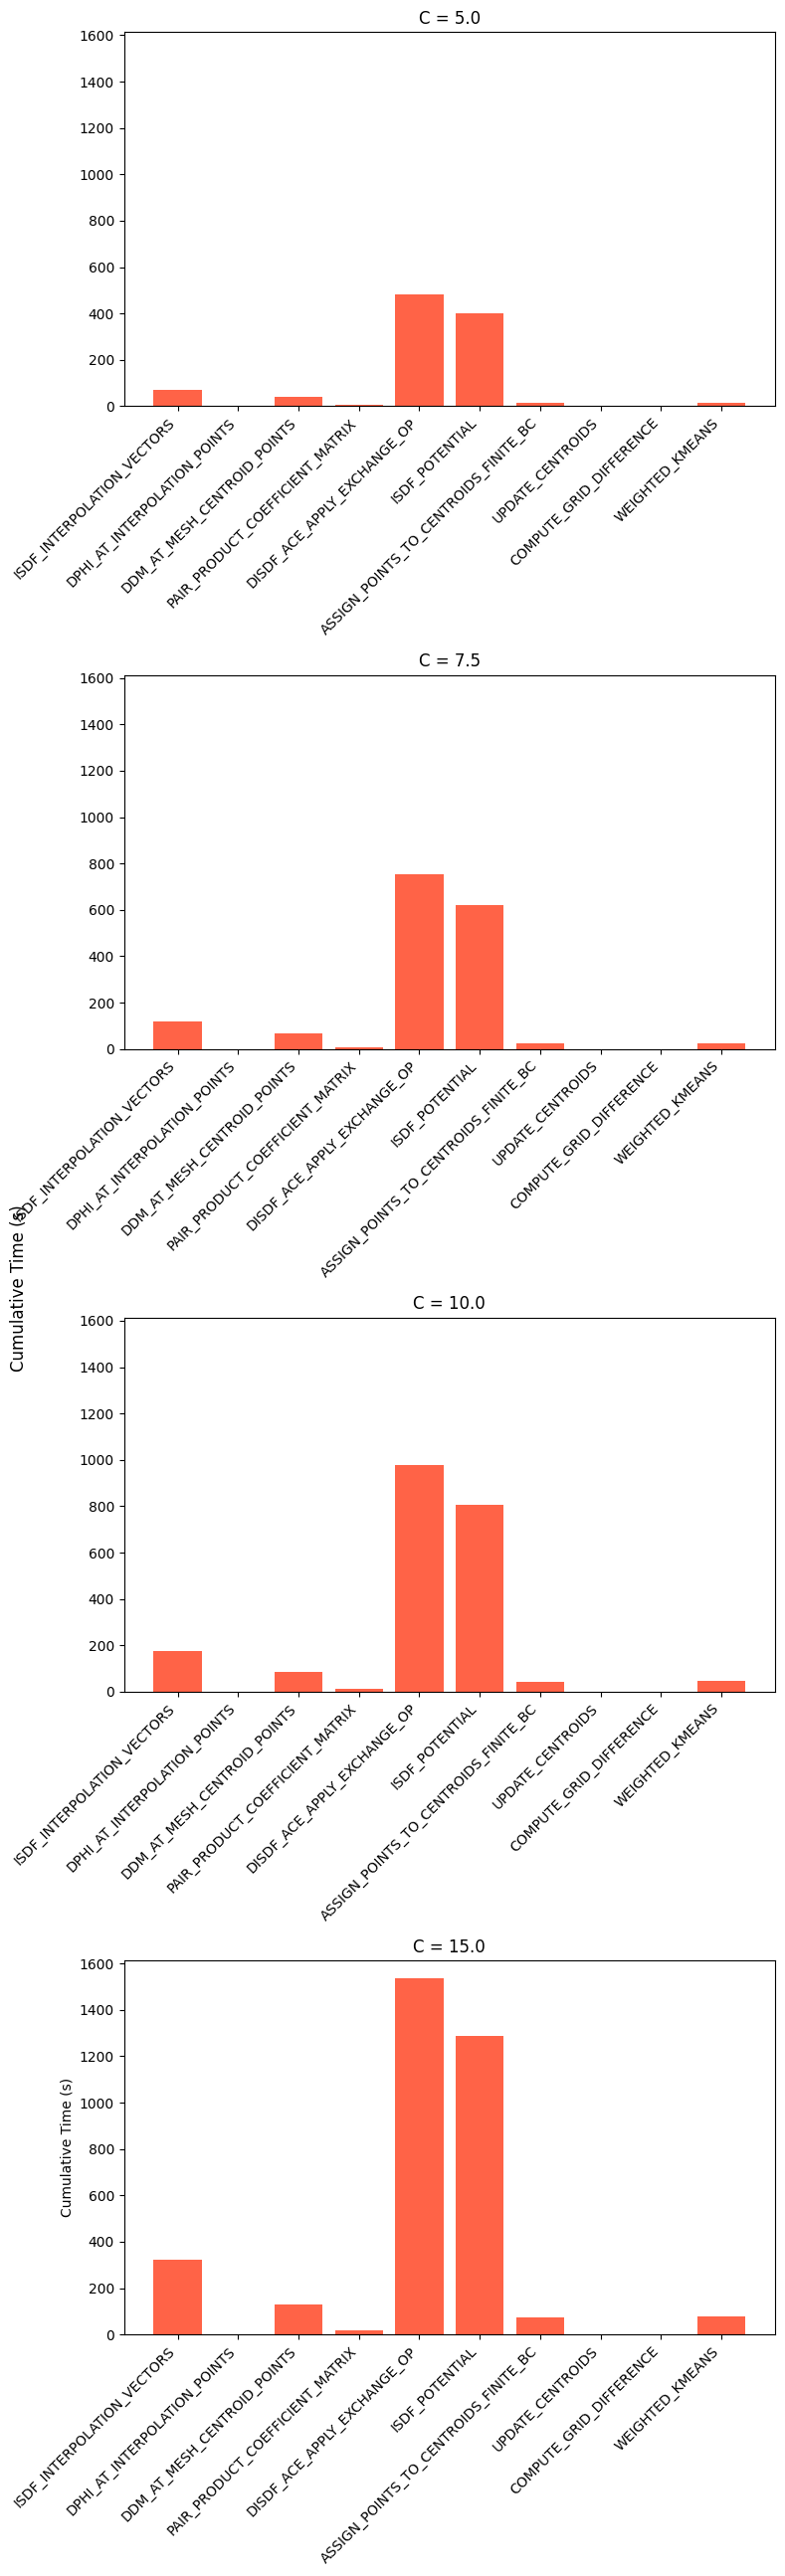

In [92]:
import math

"""
Where the time is spent most, for the esther crown. One plot for each number of ISDF vectors
* Parse data
* Plot data
"""
import matplotlib.pyplot as plt
import numpy as np

# Functions
def add_bars(ax, labels, values, *, label=None, color=None, width=0.8, rot=45):
    x = np.arange(len(labels))
    ax.bar(x, values, width=width, label=label, color=color)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=rot, ha='right')
    if label:
        ax.legend()
    return ax

to_total_time = lambda t, routines: [t[name]['TOTAL_TIME'] for name in routines]
to_time_per_call = lambda t, routines: [t[name]['TIME_PER_CALL'] for name in routines]

# Parse data
molecule = 'ether_crown'
subdirs = ['5_nocc', '7.5_nocc', '10_nocc', '15_nocc']

isdf_timing = {}
for subdir in subdirs:
    cumulative, self = parse_time(isdf_root / subdir / molecule / "profiling/time.000000")
    prefactor = float(subdir.split('_')[0])
    isdf_timing[prefactor] = cumulative
    
    
# TODO Select different colours for ISDF vectors and points routines
# Extract times of relevant routines
isdf_routines = ['ISDF_INTERPOLATION_VECTORS',
            'DPHI_AT_INTERPOLATION_POINTS',
            'DDM_AT_MESH_CENTROID_POINTS',
            'PAIR_PRODUCT_COEFFICIENT_MATRIX',
            'DISDF_ACE_APPLY_EXCHANGE_OP',
            'ISDF_POTENTIAL']

kmeans_routines = ['ASSIGN_POINTS_TO_CENTROIDS_FINITE_BC',
                   'UPDATE_CENTROIDS',
                   'COMPUTE_GRID_DIFFERENCE',
                   'WEIGHTED_KMEANS']

# Plotting
n_vertical = 4
n_horizontal = math.ceil(len(subdirs) / n_vertical)

# Pick per-panel sizing
width_per_col  = 8.0   # inches per column
height_per_row = 6.5   # inches per row

fig, axes = plt.subplots(
    n_vertical, n_horizontal,
    figsize=(width_per_col * n_horizontal, height_per_row * n_vertical),
    sharey=True
)
axes_flat = np.ravel(axes)  # 1D view for easy zipping

# Plot each panel
for ax, (prefactor, cumulative) in zip(axes_flat, isdf_timing.items()):
    add_bars(ax, isdf_routines+kmeans_routines, to_total_time(cumulative, isdf_routines+kmeans_routines), color='tomato')
    ax.set_title(f'C = {prefactor}')

# Hide any leftover empty panels
for ax in axes_flat[len(isdf_timing):]:
    ax.axis('off')

# Space out the panels
fig.subplots_adjust(wspace=0.35, hspace=0.35)
fig.tight_layout()

fig.supylabel('Cumulative Time (s)')

save_image = True
if save_image:
    # Pick the last actually-used axes
    n_used = min(len(isdf_timing), len(axes_flat))
    ax_last = axes_flat[n_used - 1]
    
    # If you rely on fig.supylabel(), give this axes its own ylabel for the export
    ax_last.set_ylabel('Cumulative Time (s)')
    
    # You must draw first so Matplotlib knows text sizes
    fig.canvas.draw()
    
    # Tight bbox for the axes (title, ticks, labels included)
    renderer = fig.canvas.get_renderer()
    bbox = ax_last.get_tightbbox(renderer, call_axes_locator=True)
    
    # Convert from display to inches
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    
    # Optional: pad a little
    bbox = bbox.padded(0.02)

    # Remote path
    file = Path.cwd() / "programs/isdfBenchmarks/jupyter/images"
    fig.savefig(file / "isdf_profiling_ethercrown.png", dpi=300, bbox_inches=bbox)

# plt.show()

## What Do These Results Show?

### Target Error, and Corresponding Molecular Speed-Up

Head-Gordon et. al. quotes an error of $10^{-6}$ (Ha / atom) as an acceptable precision in the exact exchange energy (EXX), comparable with other density-fitting methods. They also note that for range-separated hybrids where one uses a percentage of exact exchange, one may be able to get away with a higher error.

To achieve this precision in the EXX with their THC-oo-K algorithm (effectively what we also implement) they typically need a pre-factor $\sim 70$ for periodic systems, as shown in figure 1 c). In general, they find less interpolation vectors are required for molecules than periodic systems. For a benzene molecule, they use $c=20$, and typically find 25 points is sufficient (cite ref 32) for all basis sets other than the smallest. However, for molecular systems they use the THC-AO-K algorithm, in which they compute the expensive terms in the AO basis, outside of the SCF loop. We therefore cannot directly compare to this. No prefactors are presented for the THC-oo-K algorithm for molecular systems.

Looking at Lin Lin, they get ()...

For the current Octopus molecular implementation to achieve the same precision on the systems I've tested (some not included here), we need a smaller pre-factor of 10-12. However, this currently only corresponds to a speed-up on the reference implementation of $\sim 3$. If one looks at figure 4, in all cases the majority of calculation time comes from `ISDF_ACE_APPLY_EXCHANGE_OP`, and this calls `ISDF_POTENTIAL`. I.e. the main cost is just solving the Poisson equation for each interpolation vector. There are three clear implications from this:

1. For molecular systems, one needs to go to a larger number of occupied states to see meaningful speed-ups, where $O(12N_{occ} >> O(N_{e}^2)$ . This is referenced by Head-Gordon et. al. where they state, "molecular THC was seen to require too many interpolation points to be computationally competitive except for very large systems". Looking at this in context with the Lin Lin results, I don't think one should be too surprised at the Octopus molecular results. It indicates everything's working, and the code developed for this can be added to (rather than substantially modified) to extend to periodic systems.

2. If one can choose a more optimal set of interpolation points, the same precision could be obtained with fewer vectors.

3. Anything one can do to improve the efficiency of our Poisson solver will yield the largest gains - in all implementations.

For point 2, I can definitely optimise how I choose interpolation points. The `KMeans ||` and `KMeans++` (cite) algorithms provide more robust seeding and optimisation of interpolation points, respectively. And I can improve my convergence criterion, such that points don't "jiggle" between assignments. This could reduce the number of points by 10-20% required for a given precision.

For point 3, as already discussed, we could definitely implement batching of calling the Poisson solver. This could speed up the FFTs by 2x on CPU (and more on GPU). We could also implement Kresse's new cutoff for 2-4x speed-ups.

Additionally, in figure 1, the increase time w.r.t. Nisdf vectors is not quite linear. I assume this is because of the communication overhead of the vectors. I should be able to minimise this by refactoring to minimise comms. This and point 2 get up to $\sim 4x$ speed-up for molecular systems containing $\ge 60$ occupied states.

I think the remainder of the optimisation at this point should be done on the selection of the interpolation points, as this algorithm is identical for molecular and periodic systems.

### What to Expect from the Periodic Implementation

Head-Gordon et. al. note that for periodic systems their "algorithms rely on the fact that the number of ISDF points required to yield an accurate solution will plateau quickly with the k-mesh size", and show that the THC-oo-K algorithm becomes the more efficient choice for a k-grid of (5,5,5). In general, because the of the ISDF approximation, it is clear in the periodic case that we scale like $N_k$ instead of $N_k^2$, and that due to pre-factors, one sees a benefit of this for moderately dense k-grids. The formulation is:

< ADD ME>

### Next Steps

What I intend to do next is benchmark the molecular code in TD, where it's an open question as how to one can/should treat the interpolation points as a function of time. Then I'll move on to extend the existing code to handle k-points. 

Efforts that could be done in parallel include:
* Batching of Poisson solver. 
*   Henri looking at this
* Implementation of Kresse's FFT speed-ups. 
*   I would be happy to look at this - the existing hybrid implementation could also immediately benefit from this.
* Porting of density-fitting code to GPU. 
    *  I started to look at this, but Nic has suggested it is lower priority. Alternatively I could work with Alessandro at MPCDF, who is a GPU expert.     



## Unused Points

Finding interpolation points and constructing interpolation vectors are two separate algorithms. The "KMeans" algorithm corresponds to the one for choosing interpolation points. All molecular calculations have been run in state-parallel only. 

For comparison, I could run with domain and state-parallel MPI. The density fitting approach will expose more parallelism.

For TD runs, we will need to run this every $N_t$ steps (which I eventually hope to determine dynamically, on the fly). If we do not use domain decomposition for TD runs, we don't exploit any MPI parallelism for this algorithm, and the overall performance is worse.

The only way this could be improved is looking at constructing finite support, exploiting a subgrid of points. This is 

Compare to number of points used by me to Head-Gordon calculations.
One might also need to look at how the number of interpolation points varies with the choice of octopus grid spacing.
Selection of initial points could be optimised using a better algorithm - should result in a better local minimum

Takeaway
Current scaling consistent with what other codes see for molecular density ftting - need to go to more occupied states to see more benefit
Might be able to reduce number of vectors needed for a given precision in exact exchange by improving the point seeding - have two algorithms I'm implementing for this, plus making my convergence criterion more robust. 
Periodic systems offer benefit of improved scaling w.r.t. k-points as well as in number of Poisson solvers
Head-Gorden reported this at (5,5,5) (no ref to if they have symmettry inplemented)
If we cannot distribute efficiency, comms will kill gains

KMeans will need to be run every N time steps. 

To achieve this precision in the EXX with their THC-oo-K algorithm (effectively what we also implement) they typically need a pre-factor $\sim 70$ for periodic systems. See figure 1 c). In general, they find less interpolation vectors are required for molecules than periodic systems. For a benzene molecule, they use $c=20$, and typically find 25 points is sufficient (cite ref 32) for all basis sets other than the smallest basis. This suggests that one can expect to need more interpolation points for under-converged grid spacings in Octopus (drop this line).

